In [12]:
import pandas as pd
import numpy as np
import scipy as sp
import math

%matplotlib inline
import matplotlib.pyplot as plt
import itertools

import os
import shutil
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import time


size = 128,128

### OVERALL RESULTS

In [3]:
f_results = pd.read_excel(r'results/f_results.xlsx', header = 0, index_col = 0)

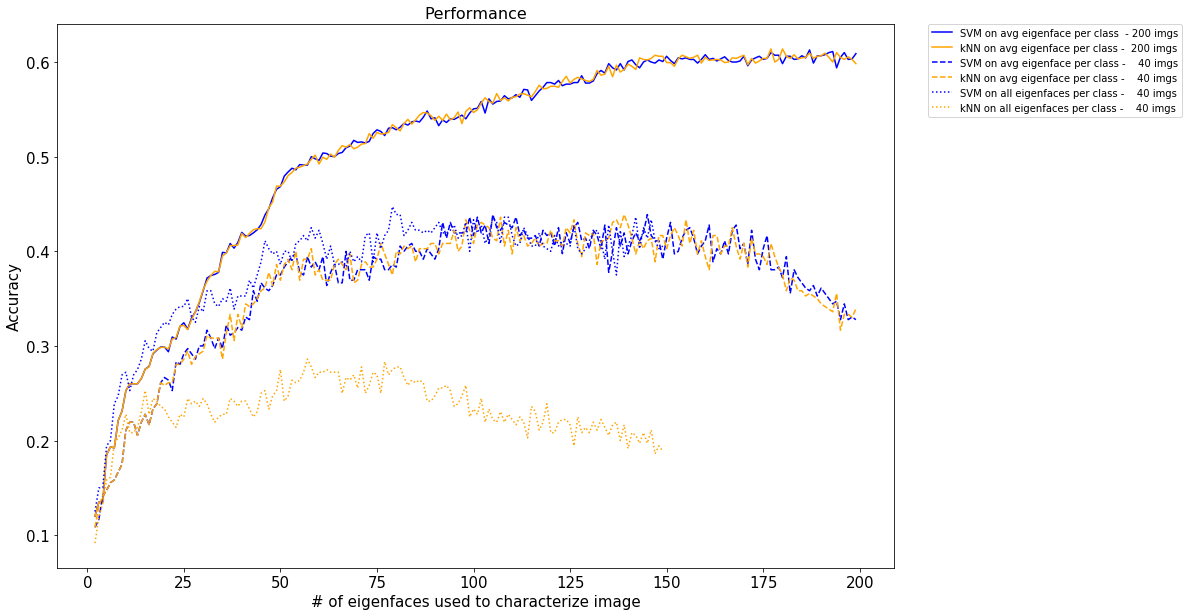

In [11]:
# number of eigenfaces and accuracy

fig, axes = plt.subplots(figsize = [15,10])

plt.plot(f_results['f_svm_g_200'], c = 'blue', label = 'SVM on avg eigenface per class  - 200 imgs' )
plt.plot(f_results['f_knn_g_200'], c = 'orange', label = 'kNN on avg eigenface per class -  200 imgs')
plt.plot(f_results['f_svm_g_40'], ls = '--', c = 'blue', label = 'SVM on avg eigenface per class -    40 imgs')
plt.plot(f_results['f_knn_g_40'], ls = '--', c = 'orange', label = 'kNN on avg eigenface per class -    40 imgs')
plt.plot(f_results['f_svm_ug_40'], ls = ':', c = 'blue', label = 'SVM on all eigenfaces per class -    40 imgs' )
plt.plot(f_results['f_knn_ug_40'], ls = ':', c = 'orange', label = 'kNN on all eigenfaces per class -    40 imgs')

#.loc[2:149]

axes.legend(loc='upper right', bbox_to_anchor=(1.35, 1.01))

plt.title('Performance', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('# of eigenfaces used to characterize image', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.show()

### Index folders and files

In [13]:
# Initialize some variables / containers
folder_list = os.listdir('f_center') # folder list

# create dictionary that maps key to number of files per name folder
len_dict = {}

for i, folder in enumerate(folder_list):
    num_files = len(os.listdir('f_center\%s' %folder)) 
    len_dict[i] = num_files
    
# Create hash that maps previous key to actual names
df_target_info = pd.DataFrame(index = list(len_dict.keys()), data = os.listdir('f_center'), columns = ['name'])
df_target_info['n_im'] = len_dict.values()

In [34]:
#Delete all celebrities with less than 200 pictures
#mask = df_target_info[df_target_info['n_im'] < 200]['name'].values
#for i in mask:
#    shutil.rmtree(r'f_center\%s' %i)

### Create X

In [14]:
im_temp = []                                    # temporary store for image files in for-loop, later converted to array

idx = 0                                         # manual idx counter for the jpg -> name dict (useful to preserve order)
idx_jpg_hash = {}                             # dictionary hash for jpb -> name
idx_name_hash = {}

# Index folder and files, store images in a flattened array, create a handy hash to lookup jpgs to name later
# NOTE: downsampling all images to folder with lowest # images
start_time = time.time()

for folder in folder_list:
    file_list = os.listdir('f_center\%s' %folder)    
    
    for file in file_list[:200]:             # downsampling to 200, alternative min imgs: min(len_dict.values())
        im_temp = im_temp + [np.array(Image.open(r'f_center\%s\%s' %(folder, file))\
                             .convert(mode='L').resize(size, Image.ANTIALIAS)).ravel()]
    
        idx_jpg_hash[idx] = file                             
        idx_name_hash[idx] = folder
        idx += 1

X = np.array(im_temp)

print("Time taken: {:.2f} seconds".format(time.time() - start_time))

Time taken: 13.05 seconds


### Create y

In [15]:
# Create target 
y = []
for key in list(len_dict.keys()):
    y += 200 * [list(len_dict.keys())[key]]    #Downsampling to 200, alternative min imgs: min(len_dict.values())

In [16]:
# Create list of classes to be used for confusion matrix later on
target_classes = folder_list 

numcat_hash = {}
for i, name in enumerate(target_classes):
    numcat_hash[i] = name

### Split data into a training and testing set

In [17]:
# Stratified split, on target class (y)
indices = np.arange(0,X.shape[0])
X_train, X_test, y_train, y_test, indices_train,indices_test = train_test_split(X, y, indices, test_size=0.25, stratify = y, random_state=42)

### PCA + SVM

#### Plot explained variance

In [19]:
start_time = time.time()

n_components = 40

pca = PCA( n_components = n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

print("Time taken: {:.2f} seconds".format(time.time() - start_time))

Time taken: 3.96 seconds


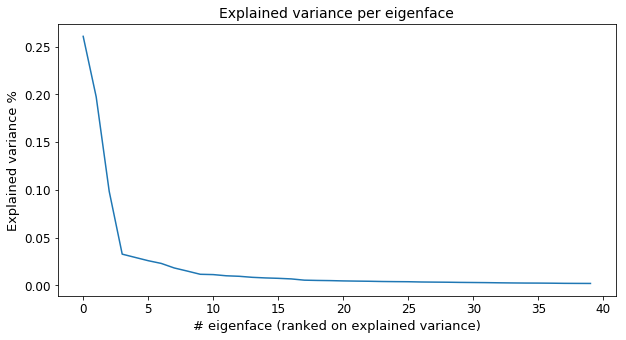

In [20]:
#print(pca.explained_variance_ratio_)

fig, axes = plt.subplots(figsize = [10,5])
plt.plot(pca.explained_variance_ratio_)
plt.title('Explained variance per eigenface', fontsize = 14)
plt.ylabel('Explained variance %', fontsize = 13)
plt.xlabel('# eigenface (ranked on explained variance)', fontsize = 13)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

#### Find best value for eigenfaces and hyperparameters

In [42]:
from sklearn.model_selection import StratifiedKFold

results_svm = pd.DataFrame(index = np.arange(2,200), data = 0, columns = ['C', 'gamma', 'best_score'] )

param_grid = {'C': [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 0.1, 0.3, 1, 1.5, 2, 2.5, 3, 1e2   ],
              'gamma': [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 1e-2, 0.03, 0.1,  0.3, 1, 3, 10 ] }

for i in np.arange(2,200):
    start_time = time.time()
    
    n_components = i
    pca = PCA(n_components= n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
    
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    scores = []

    for j in param_grid['C']:
        for k in param_grid['gamma']:
            skf = StratifiedKFold(n_splits=3)
            for train_index, test_index in skf.split(X_train_pca, y_train):
                X_train_pca_G, y_train_G = pca_group_function(X_train_pca[train_index], np.array(y_train)[train_index])
    
                clf = SVC(C = j, gamma = k, kernel='rbf', class_weight='balanced')
                clf = clf.fit(X_train_pca_G, y_train_G)

                y_pred = clf.predict(X_train_pca[test_index])
                y_true = np.array(y_train)[test_index]
                scores = scores+ [accuracy_score(y_pred, y_true)]

            mean_test_score = np.average(scores)
            
            if mean_test_score > results_svm.loc[i, 'best_score']:         
                results_svm.loc[i, 'C'] = j
                results_svm.loc[i, 'gamma'] = k
                results_svm.loc[i, 'best_score'] = mean_test_score
            
    print('# eigenfaces: ', i)
    print('C: ', results_svm.loc[i, 'C'], 'gamma: ', results_svm.loc[i, 'gamma'] )
    print('Best_score: ', results_svm.loc[i, 'best_score'] )
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    print()
    

# eigenfaces:  2
C:  0.0001 gamma:  0.03
Best_score:  0.12
Time taken: 5.02 seconds

# eigenfaces:  3
C:  0.0001 gamma:  0.001
Best_score:  0.135
Time taken: 4.94 seconds

# eigenfaces:  4
C:  0.0001 gamma:  1.0
Best_score:  0.135
Time taken: 4.81 seconds

# eigenfaces:  5
C:  0.0003 gamma:  0.3
Best_score:  0.185
Time taken: 4.88 seconds

# eigenfaces:  6
C:  0.0001 gamma:  0.1
Best_score:  0.193333333333
Time taken: 4.56 seconds

# eigenfaces:  7
C:  0.0001 gamma:  0.0003
Best_score:  0.192222222222
Time taken: 4.82 seconds

# eigenfaces:  8
C:  0.0003 gamma:  3e-05
Best_score:  0.221111111111
Time taken: 5.25 seconds

# eigenfaces:  9
C:  0.001 gamma:  0.0003
Best_score:  0.231111111111
Time taken: 6.54 seconds

# eigenfaces:  10
C:  0.0003 gamma:  0.0001
Best_score:  0.252777777778
Time taken: 6.23 seconds

# eigenfaces:  11
C:  0.0003 gamma:  0.01
Best_score:  0.26
Time taken: 5.91 seconds

# eigenfaces:  12
C:  0.0001 gamma:  0.03
Best_score:  0.26
Time taken: 5.84 seconds

# eig

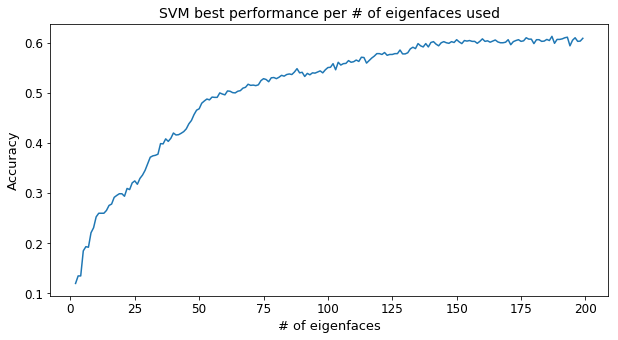

In [43]:
# number of eigenfaces and accuracy

fig, axes = plt.subplots(figsize = [10,5])
plt.plot(results_svm['best_score'])
plt.title('SVM best performance per # of eigenfaces used', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 13)
plt.xlabel('# of eigenfaces', fontsize = 13)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [65]:
#results_svm.to_excel('f_svm_g_200im.xlsx', sheet_name='CM', index=True)

In [23]:
print('best results:')
results_svm[results_svm['best_score']== max(results_svm['best_score'])]

best results:


,C,gamma,best_score
147,0.01,0.0001,0.607222


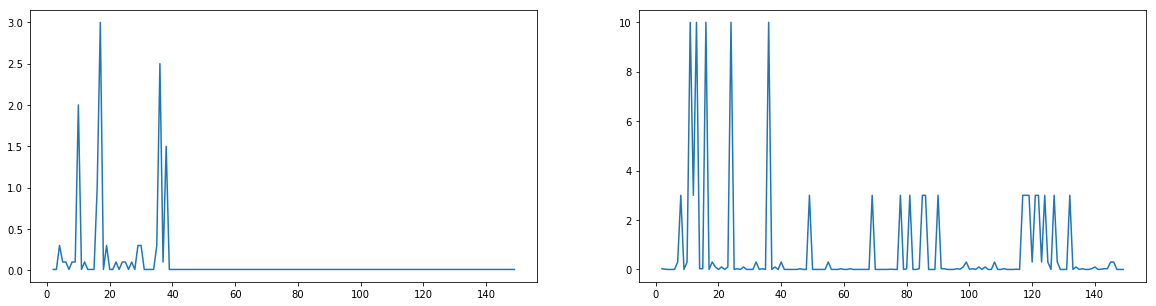

In [108]:
fig, axes = plt.subplots(1,2, figsize = [20,5])
axes[0].plot(results_svm['C'])
axes[1].plot(results_svm['gamma'])
plt.show()

#### Show eigenfaces of best result

In [181]:
start_time = time.time()

n_components = 147

pca = PCA(n_components= n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

# eigenfaces expressed as the weighted original features
eigenfaces = pca.components_.reshape((n_components, size[0], size[1]))

# images expressed as weighted eigenfaces
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca_G, y_train_G = pca_group_function(X_train_pca, np.array(y_train))
    
clf = SVC(C = .01, gamma = 0.0001, kernel='rbf', class_weight='balanced')
clf = clf.fit(X_train_pca_G, y_train_G)


print("Time taken: {:.2f} seconds".format(time.time() - start_time))

Time taken: 7.14 seconds


#### First 15 eigenfaces

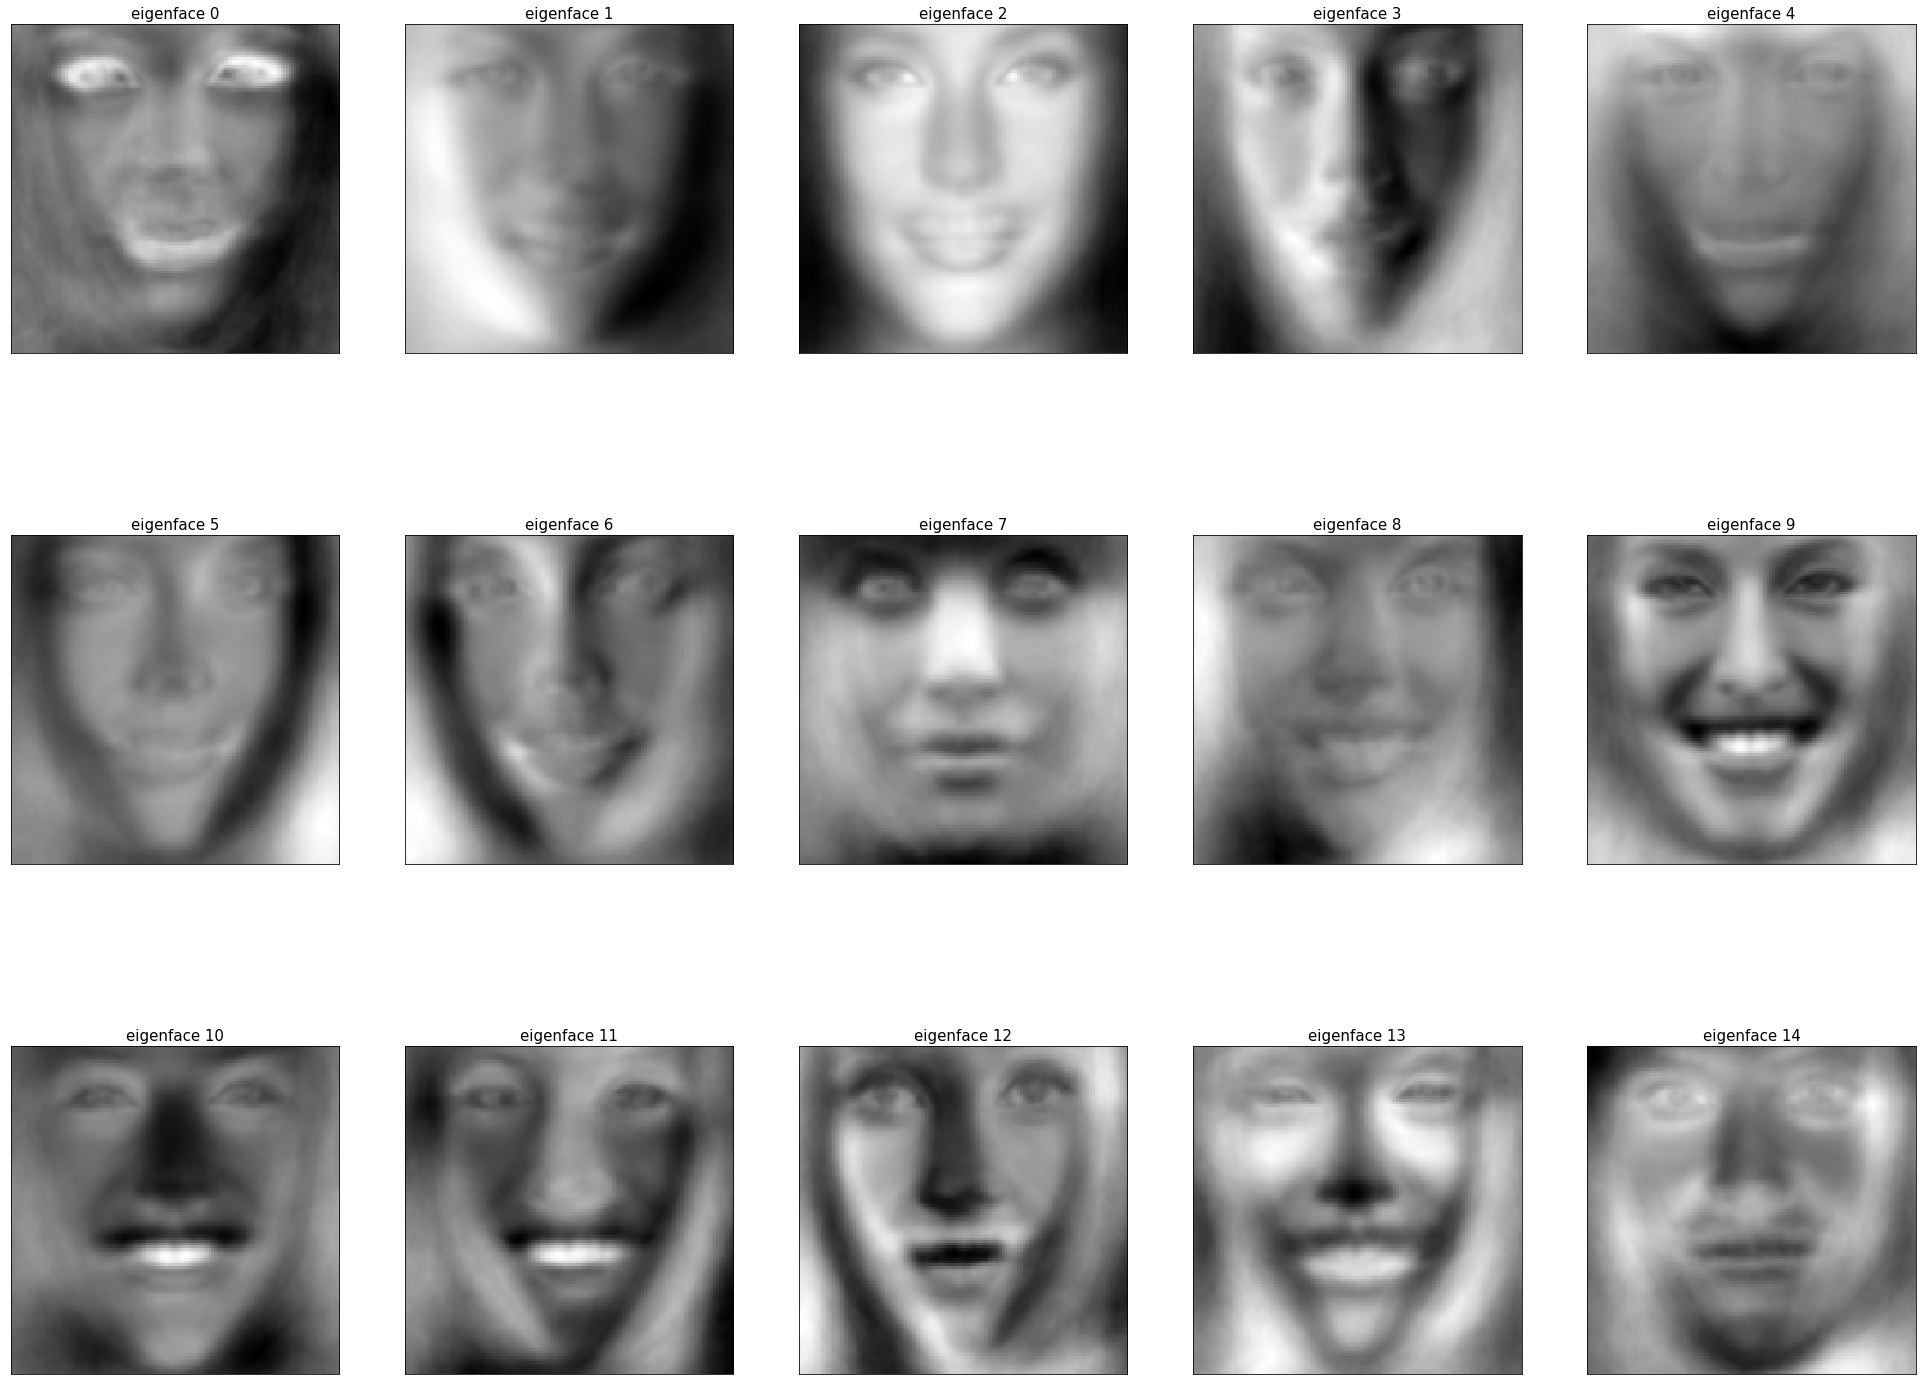

In [25]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces[0:15], eigenface_titles[0:15], size[0], size[1], n_row=3, n_col=5)

#### Last 15 eigenfaces

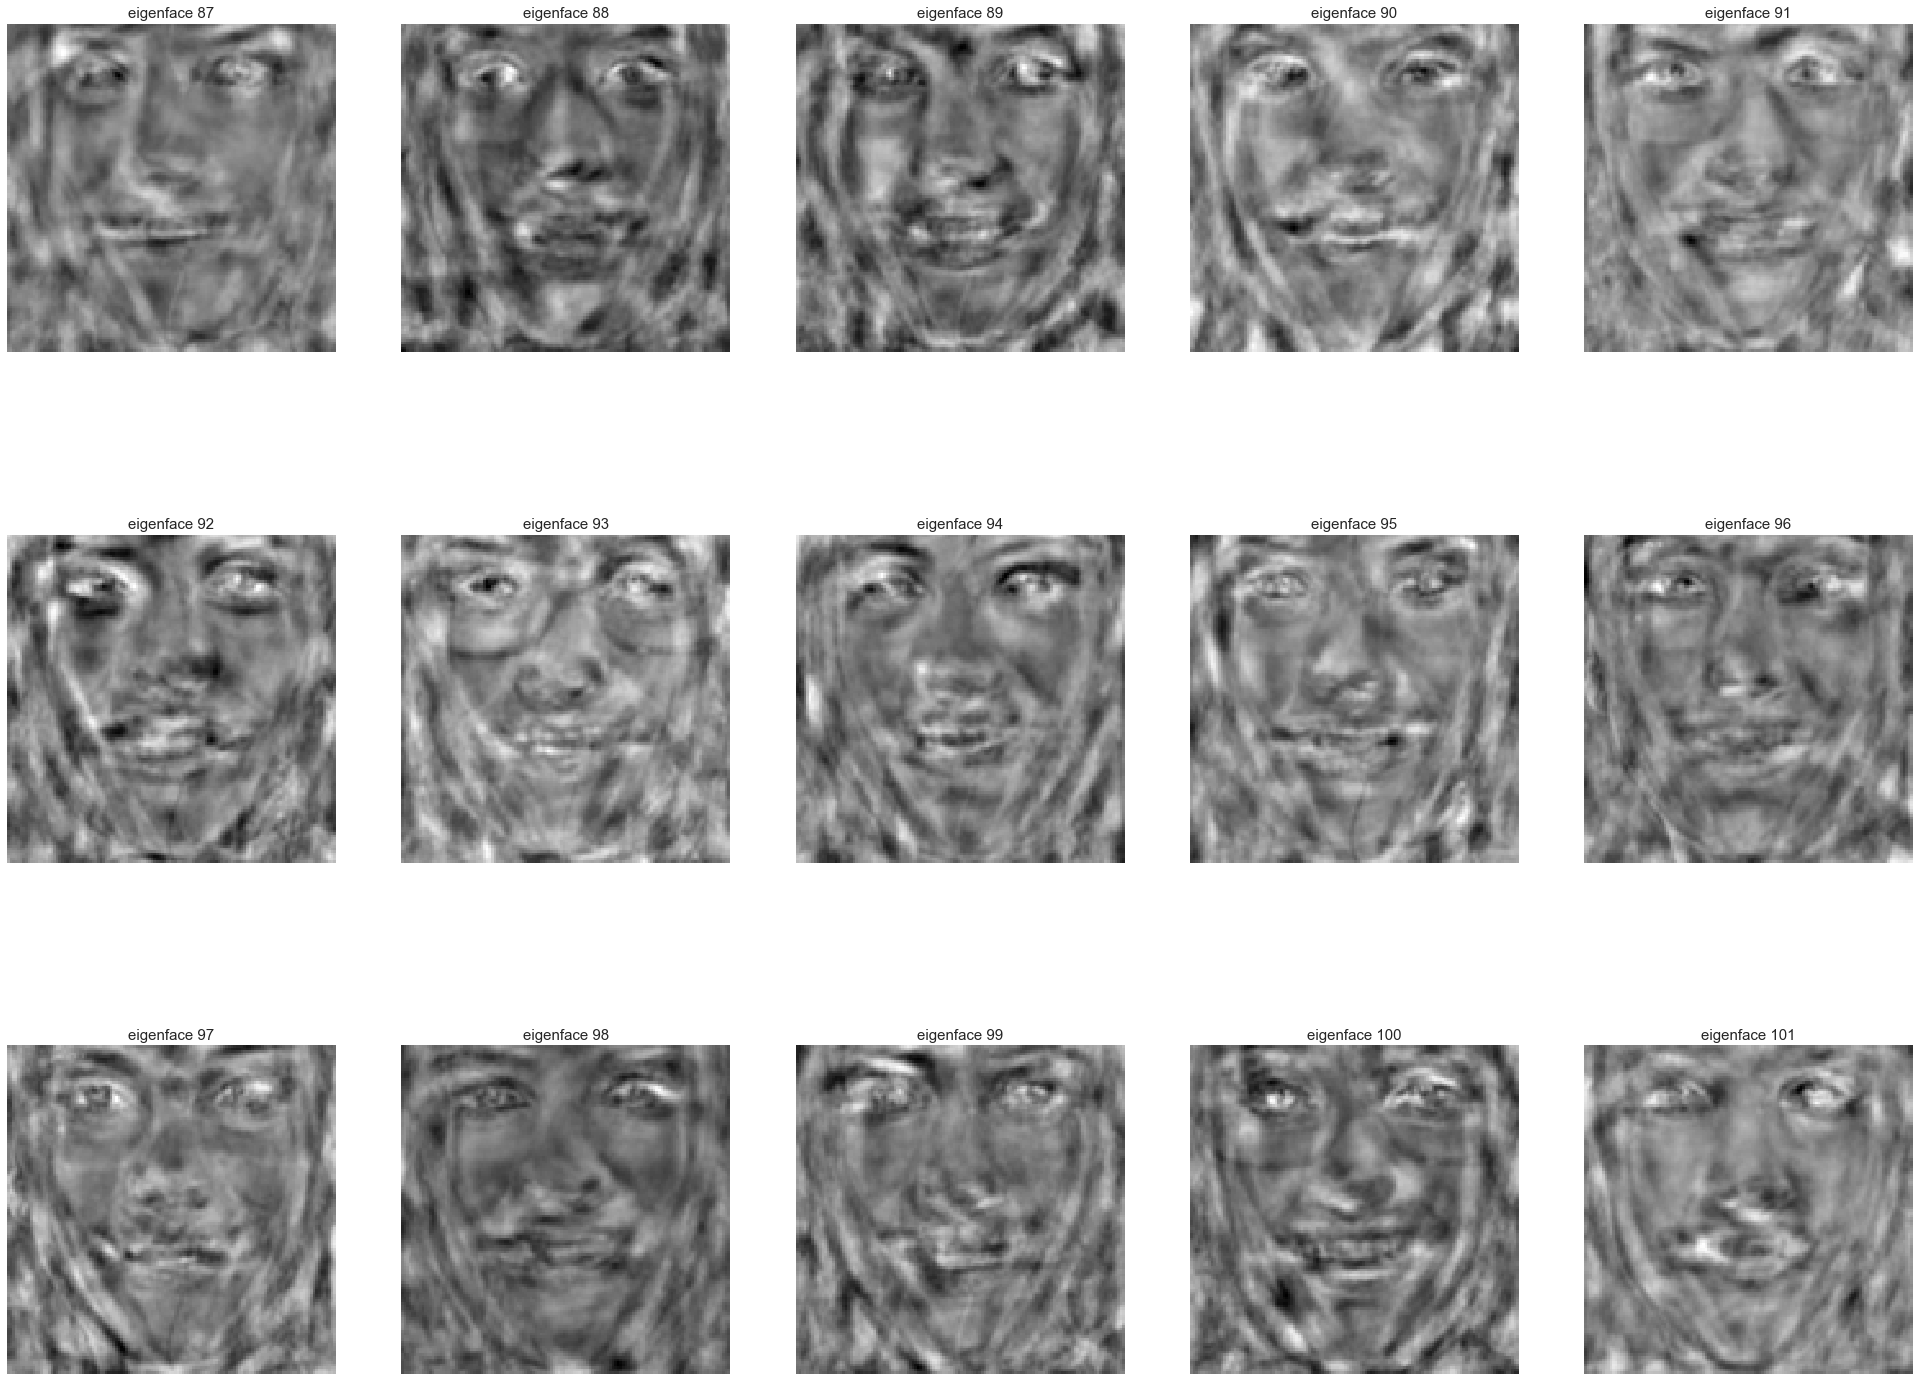

In [225]:
plot_gallery(eigenfaces[87:102], eigenface_titles[87:102], size[0], size[1], n_row=3, n_col=5)

#### Average eigenface (substracted from all images in PCA)

([], <a list of 0 Text yticklabel objects>)

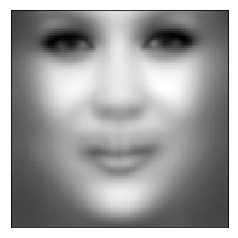

In [26]:
fig, axes = plt.subplots()
plt.imshow(pca.mean_.reshape((size[0], size[1])), cmap=plt.cm.gray)
plt.xticks(())
plt.yticks(())


### Performance on test set

Overall accuracy:  58.8333333333 percent

Per class metrics
                   precision    recall  f1-score   support

   Angelina_Jolie       0.46      0.52      0.49        50
     Blake_Lively       0.64      0.60      0.62        50
     Cameron_Diaz       0.63      0.54      0.58        50
  Charlize_Theron       0.52      0.60      0.56        50
    Courteney_Cox       0.52      0.54      0.53        50
 Jennifer_Aniston       0.46      0.46      0.46        50
  Jennifer_Garner       0.57      0.56      0.57        50
     Jessica_Alba       0.77      0.66      0.71        50
 Leighton_Meester       0.62      0.72      0.67        50
    Nicole_Kidman       0.61      0.60      0.61        50
Reese_Witherspoon       0.70      0.78      0.74        50
  Zooey_Deschanel       0.63      0.48      0.55        50

      avg / total       0.59      0.59      0.59       600

Confusion matrix


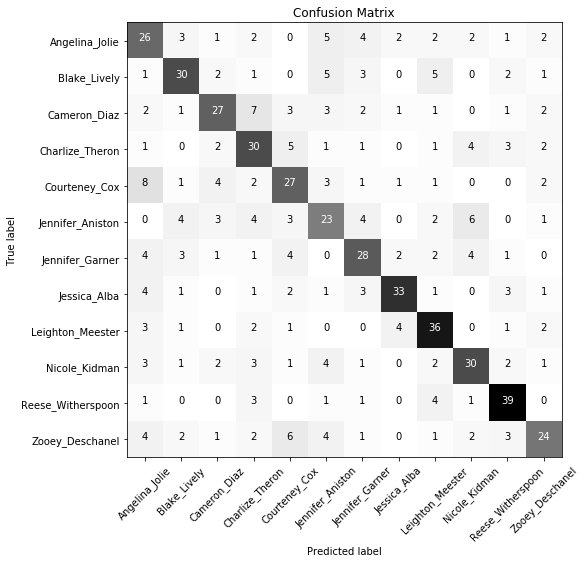

None


In [129]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test_pca)

print('Overall accuracy: ', accuracy_score(y_test, y_pred, normalize=True)*100, 'percent')
print()
print('Per class metrics')
print(classification_report(y_test, y_pred, target_names = target_classes))
print('Confusion matrix')
print(plot_confusion_matrix(y = y_test, y_pred = y_pred, target_classes = target_classes))

#confusion_matrix(y_test, y_pred, labels=np.arange(len(target_classes)))

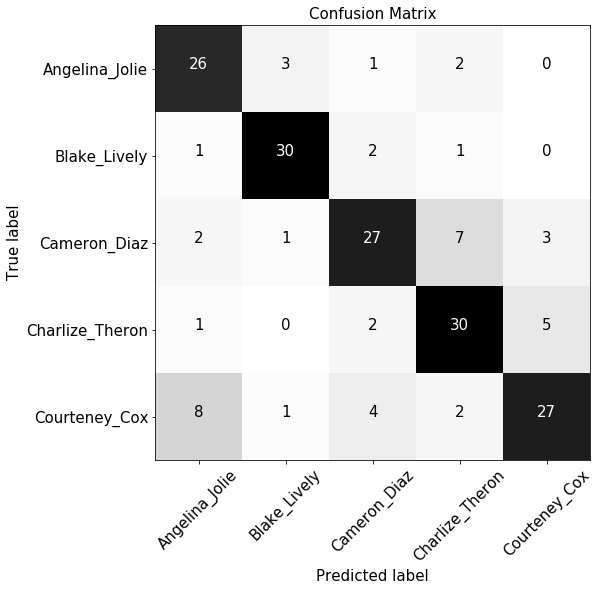

None


In [138]:
print(plot_confusion_matrix_first5(y = y_test, y_pred = y_pred, target_classes = target_classes[0:5]))

### Average faces per class

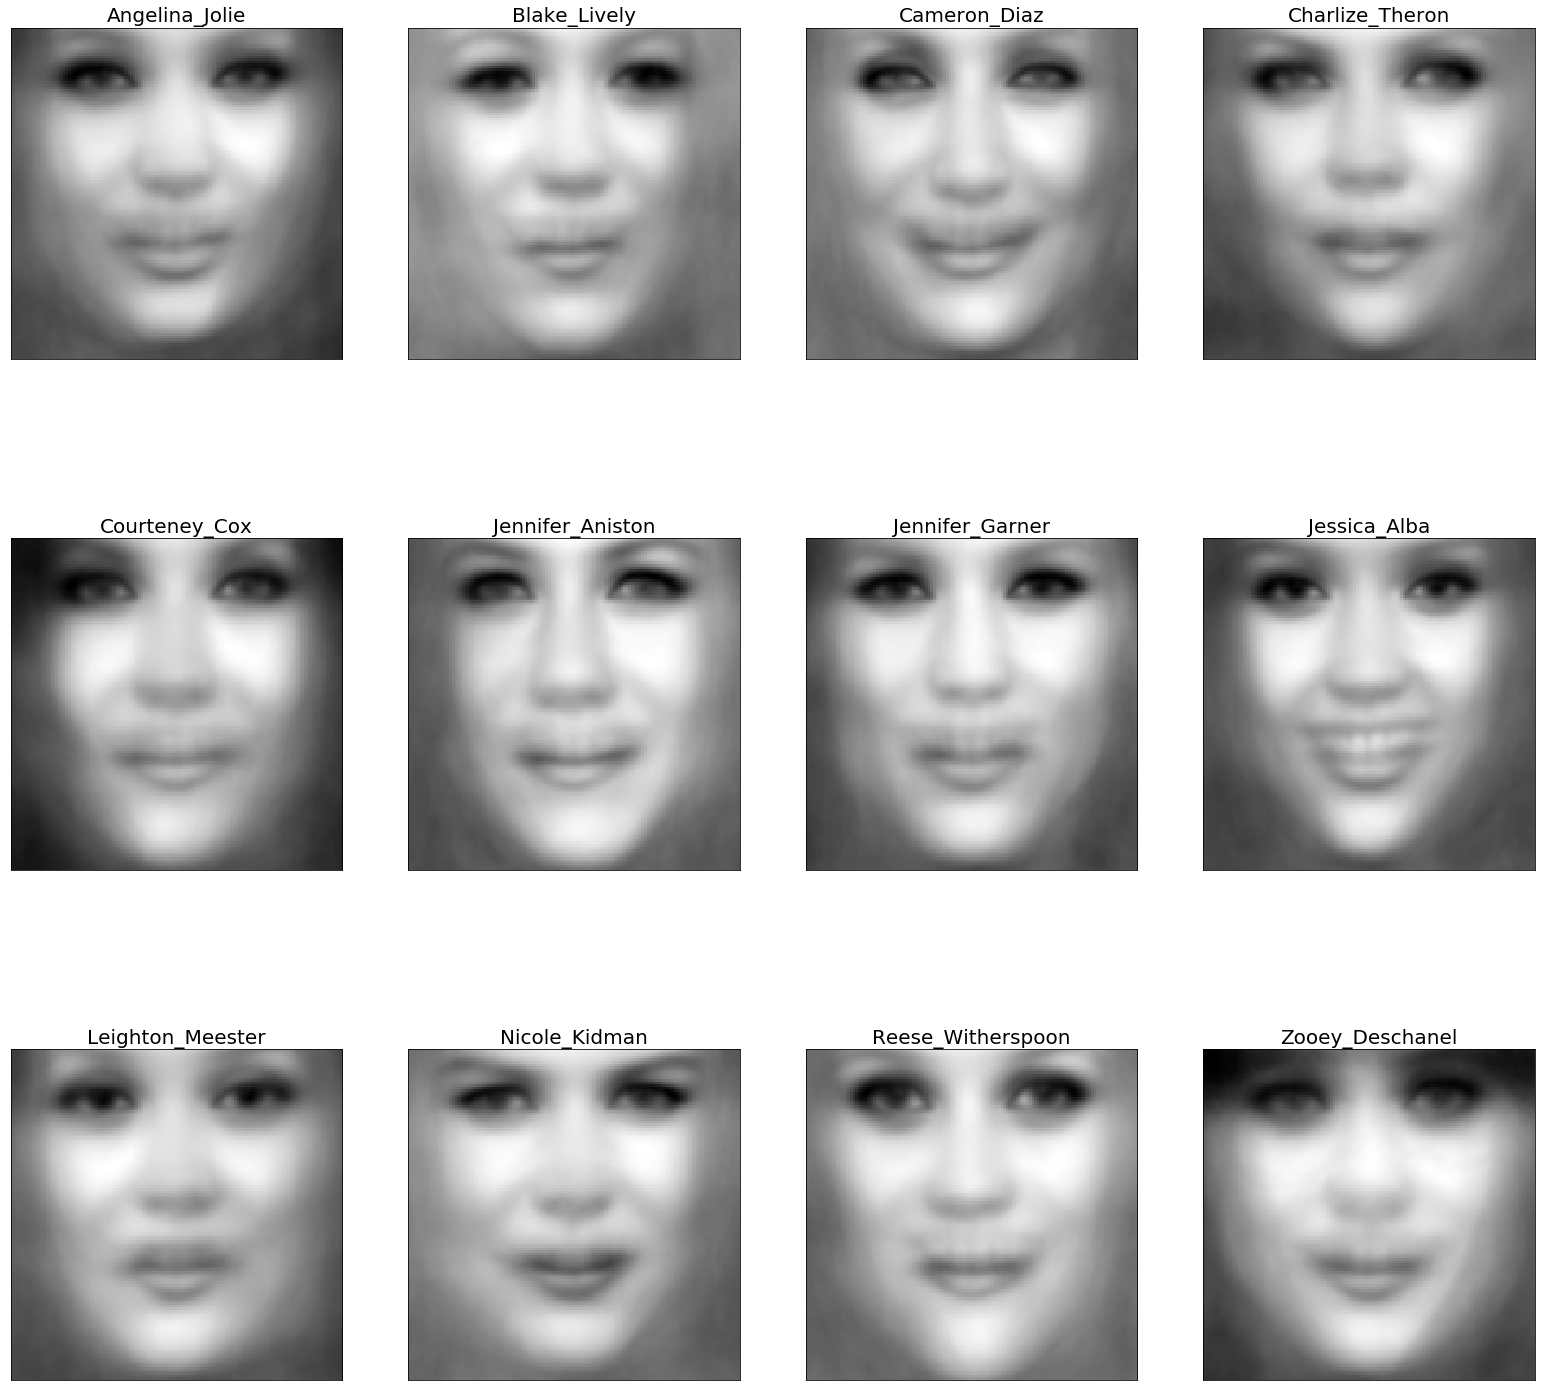

In [144]:
titles = target_classes
plot_gallery(pca.inverse_transform(X_train_pca_G), titles, size[0], size[1], n_row=3, n_col=4)

In [145]:
df = pd.DataFrame(confusion_matrix(y_test, y_pred, labels = np.arange(len(target_classes))))
#df.to_excel('CM_females.xlsx', sheet_name='CM', index=True)

In [182]:
# Create error analysis dataframe
df_error_analysis = pd.DataFrame(index = np.arange(0,len(y_test)), columns = ['orig_index','y_pred', 'y_test', 'name_pred', 'name_test', 'jpg'])
df_error_analysis['orig_index'] = indices_test
df_error_analysis['y_pred'] = y_pred
df_error_analysis['y_test'] = y_test
df_error_analysis['name_pred'] = df_error_analysis['y_pred'].map(numcat_hash)
df_error_analysis['name_test'] = df_error_analysis['y_test'].map(numcat_hash)
df_error_analysis['jpg'] = df_error_analysis['orig_index'].map(idx_jpg_hash)

Plotting correctly classified images
Total correct images:  2
Input # of rows: 
1
Input # of columns: 
2


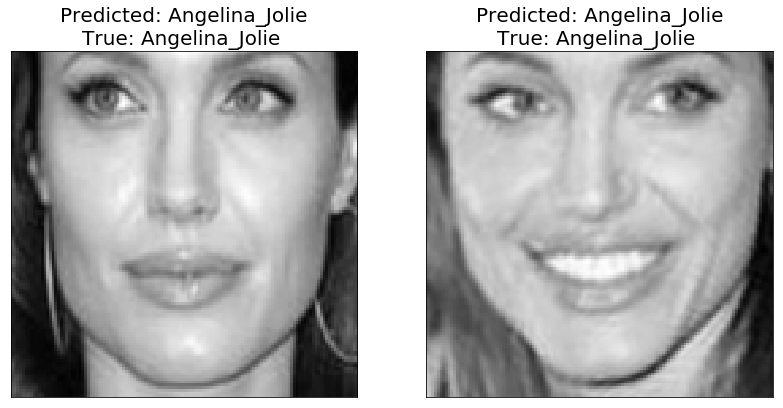

In [122]:
plot_correct()

Plotting wrongly classified images -- Recall: NOT classified as Angelina_Jolie, but should have
Total wrong images:  24
Input # of rows: 
4
Input # of columns: 
6


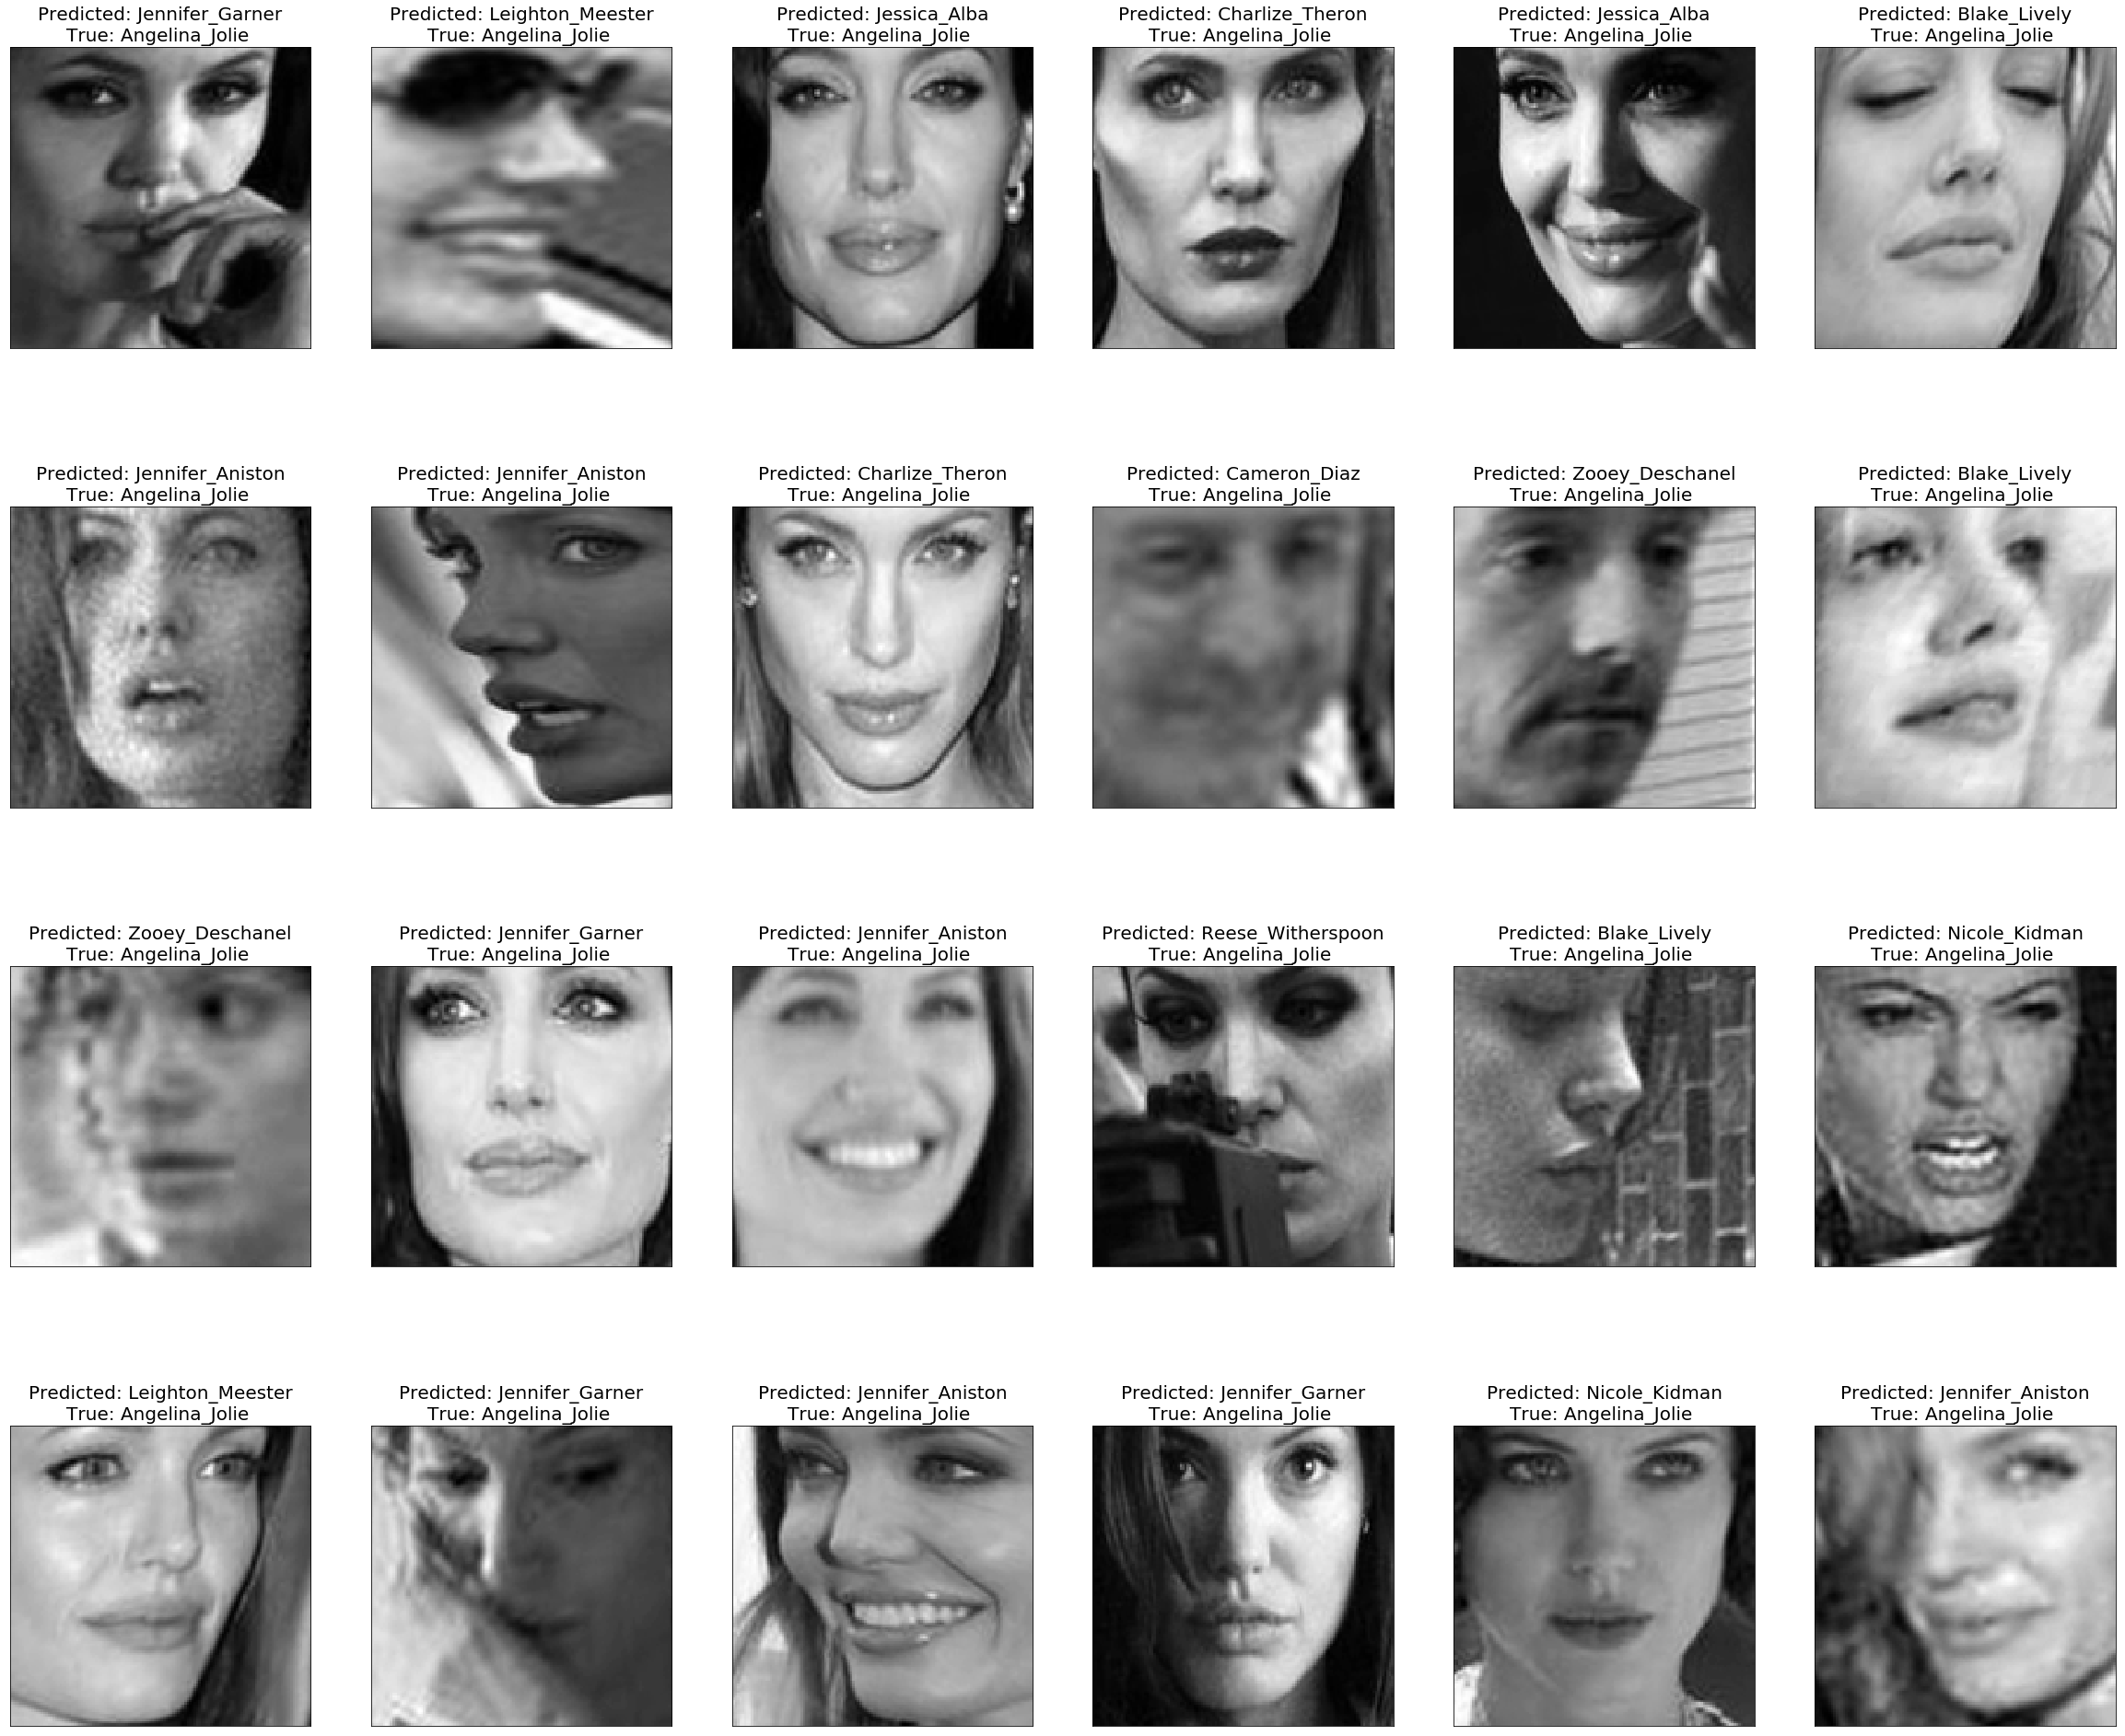

In [150]:
plot_wrong_recall()

Plotting wrongly classified images -- Precision: Classified as Angelina_Jolie, but should NOT have
Total wrong images:  3
Input # of rows: 
1
Input # of columns: 
3


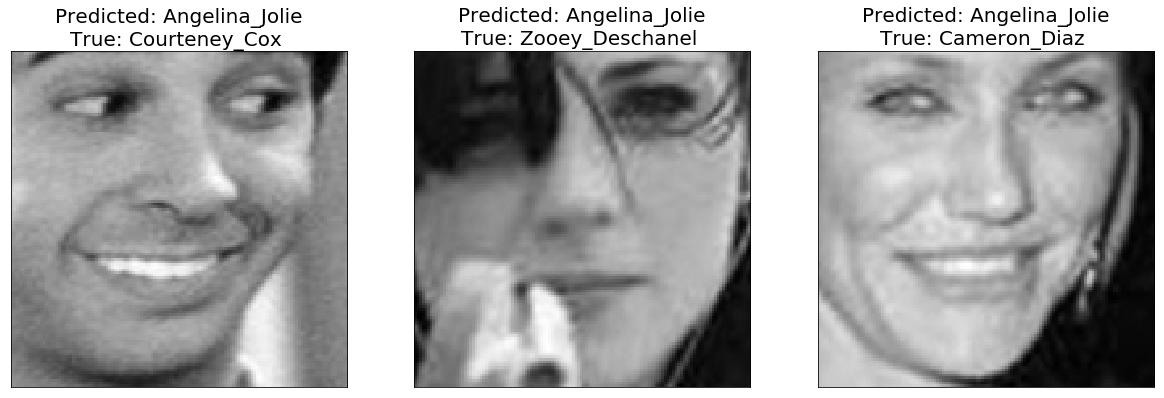

In [124]:
plot_wrong_precision()

### PCA + kNN

In [22]:
from sklearn.model_selection import StratifiedKFold

results_knn = pd.DataFrame(index = np.arange(2,200), data = 0, columns = ['knn', 'best_score'] )

param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11] }

for i in np.arange(2,200):
    start_time = time.time()
    
    n_components = i
    pca = PCA(n_components= n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
    
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    scores = []

    for j in param_grid['n_neighbors']:
        
        skf = StratifiedKFold(n_splits=3)
        for train_index, test_index in skf.split(X_train_pca, y_train):
            
            X_train_pca_G, y_train_G = pca_group_function(X_train_pca[train_index], np.array(y_train)[train_index])
    
            clf2 = KNeighborsClassifier(n_neighbors = j)
            clf2 = clf2.fit(X_train_pca_G, y_train_G)    

            y_pred = clf2.predict(X_train_pca[test_index])
            y_true = np.array(y_train)[test_index]
            scores = scores+ [accuracy_score(y_pred, y_true)]

        mean_test_score = np.average(scores)
            
        if mean_test_score > results_knn.loc[i, 'best_score']:         
            results_knn.loc[i, 'knn'] = j
            results_knn.loc[i, 'best_score'] = mean_test_score
            
    print('# eigenfaces: ', i)
    print('k: ', results_knn.loc[i, 'knn'])
    print('Best_score: ', results_knn.loc[i, 'best_score'] )
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    print()
    

# eigenfaces:  2
k:  1
Best_score:  0.12
Time taken: 3.26 seconds

# eigenfaces:  3
k:  1
Best_score:  0.135
Time taken: 2.94 seconds

# eigenfaces:  4
k:  1
Best_score:  0.135
Time taken: 3.12 seconds

# eigenfaces:  5
k:  1
Best_score:  0.185
Time taken: 3.34 seconds

# eigenfaces:  6
k:  1
Best_score:  0.193333333333
Time taken: 3.02 seconds

# eigenfaces:  7
k:  1
Best_score:  0.192222222222
Time taken: 8.65 seconds

# eigenfaces:  8
k:  1
Best_score:  0.221111111111
Time taken: 4.36 seconds

# eigenfaces:  9
k:  1
Best_score:  0.231111111111
Time taken: 3.39 seconds

# eigenfaces:  10
k:  1
Best_score:  0.252777777778
Time taken: 3.26 seconds

# eigenfaces:  11
k:  1
Best_score:  0.26
Time taken: 3.38 seconds

# eigenfaces:  12
k:  1
Best_score:  0.26
Time taken: 3.57 seconds

# eigenfaces:  13
k:  1
Best_score:  0.26
Time taken: 3.88 seconds

# eigenfaces:  14
k:  1
Best_score:  0.265555555556
Time taken: 4.87 seconds

# eigenfaces:  15
k:  1
Best_score:  0.275555555556
Time take

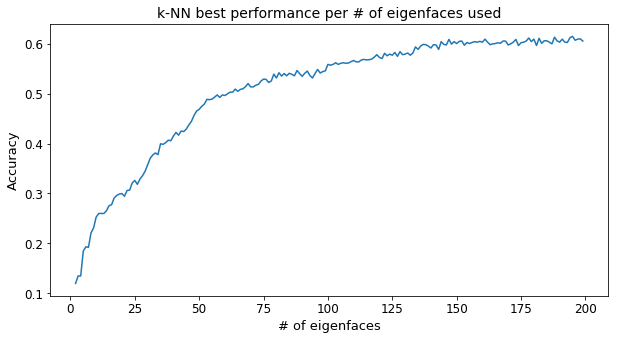

In [23]:
# number of eigenfaces and accuracy

fig, axes = plt.subplots(figsize = [10,5])
plt.plot(results_knn['best_score'])
plt.title('k-NN best performance per # of eigenfaces used', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 13)
plt.xlabel('# of eigenfaces', fontsize = 13)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [64]:
#results_knn.to_excel('f_knn_g_200im.xlsx', sheet_name='Acc', index=True)

In [24]:
print('best results:')
results_knn[results_knn['best_score']== max(results_knn['best_score'])]

best results:


,knn,best_score
195,1,0.614444


In [25]:
start_time = time.time()

n_components = 195

pca = PCA(n_components= n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

# eigenfaces expressed as the weighted original features
eigenfaces = pca.components_.reshape((n_components, size[0], size[1]))

# images expressed as weighted eigenfaces
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca_G, y_train_G = pca_group_function(X_train_pca[train_index], np.array(y_train)[train_index])
    
clf2 = KNeighborsClassifier(n_neighbors = 1)
clf2 = clf2.fit(X_train_pca_G, y_train_G)

print("Time taken: {:.2f} seconds".format(time.time() - start_time))

Time taken: 8.65 seconds


### Performance on test set

Overall accuracy:  58.6666666667 percent

Per class metrics
                   precision    recall  f1-score   support

   Angelina_Jolie       0.47      0.56      0.51        50
     Blake_Lively       0.52      0.64      0.58        50
     Cameron_Diaz       0.54      0.52      0.53        50
  Charlize_Theron       0.52      0.54      0.53        50
    Courteney_Cox       0.47      0.54      0.50        50
 Jennifer_Aniston       0.61      0.50      0.55        50
  Jennifer_Garner       0.65      0.48      0.55        50
     Jessica_Alba       0.77      0.68      0.72        50
 Leighton_Meester       0.59      0.70      0.64        50
    Nicole_Kidman       0.75      0.60      0.67        50
Reese_Witherspoon       0.67      0.78      0.72        50
  Zooey_Deschanel       0.58      0.50      0.54        50

      avg / total       0.60      0.59      0.59       600

Confusion matrix


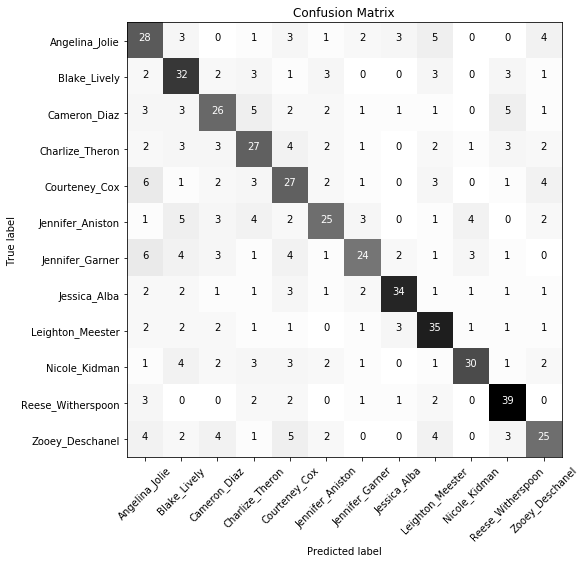

None


In [26]:
y_pred2 = clf2.predict(X_test_pca)


print('Overall accuracy: ', accuracy_score(y_test, y_pred2, normalize=True)*100, 'percent')
print()
print('Per class metrics')
print(classification_report(y_test, y_pred2, target_names = target_classes))
print('Confusion matrix')
print(plot_confusion_matrix(y = y_test, y_pred = y_pred2, target_classes = target_classes))

#confusion_matrix(y_test, y_pred, labels=np.arange(len(target_classes)))

### Average eigenface per class

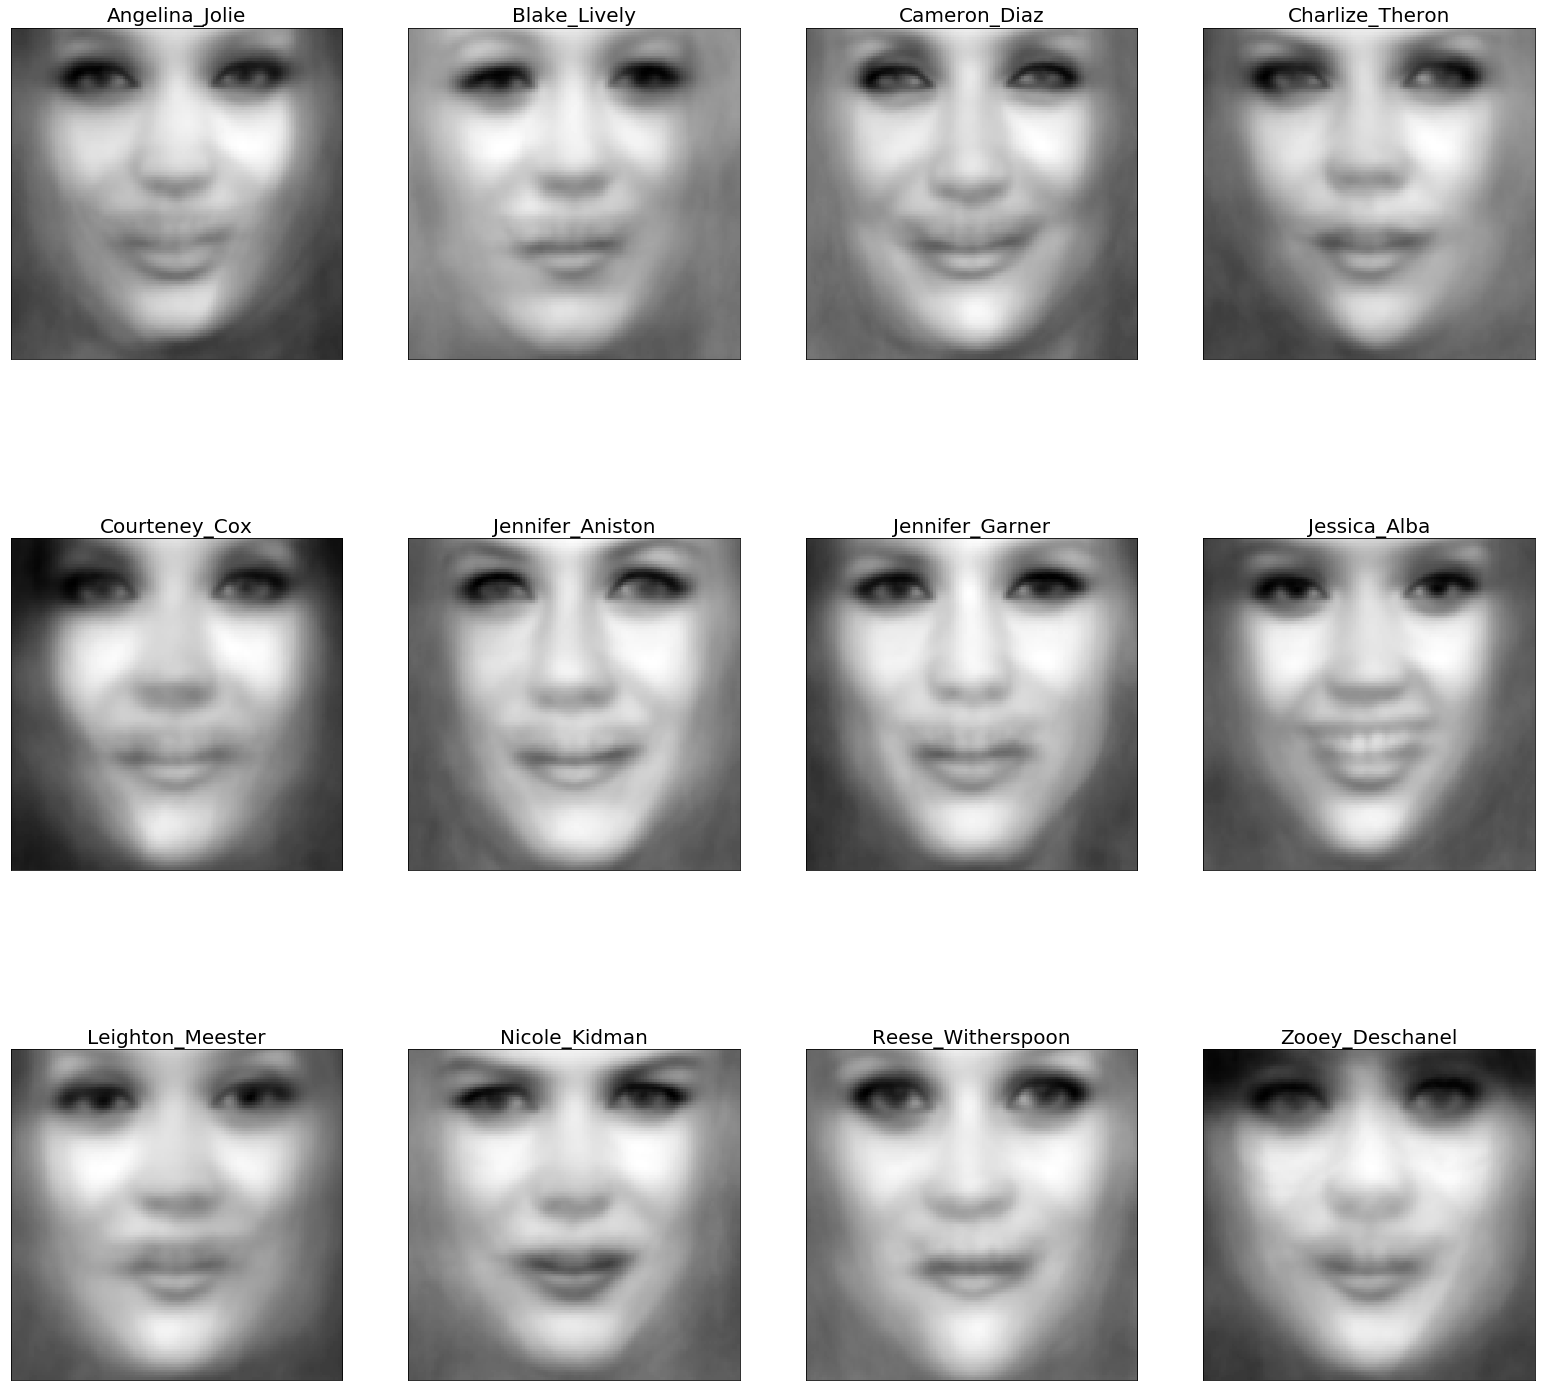

In [27]:
titles = target_classes
plot_gallery(pca.inverse_transform(X_train_pca_G), titles, size[0], size[1], n_row=3, n_col=4)

### Predicting a new picture

In [322]:
neigh = KNeighborsClassifier(n_neighbors = 1)
neigh.fit(X_train_pca, y_train)
print(neigh.kneighbors(X_test_pca[0].reshape(1,-1)))

(array([[ 2.22182551]]), array([[147]], dtype=int64))


In [327]:
yname_hash.iloc[y_train[147]]

names    Aaron_Ashmore
Name: 2, dtype: object

### Show images reconstruction

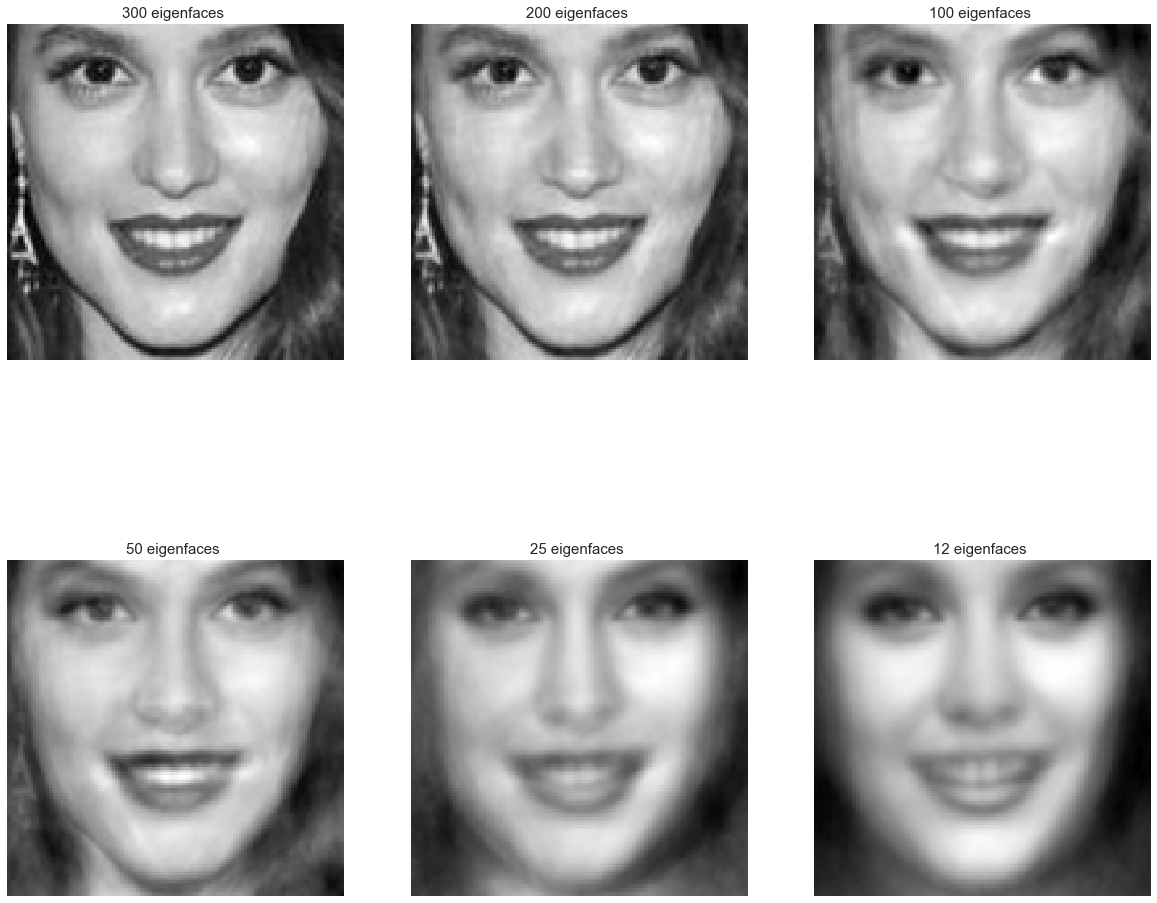

In [196]:
pca = PCA(n_components= 300, svd_solver='randomized', whiten=False).fit(X_train)
mu = pca.mean_

im_list = []
eigen_list = [300,200,100,50,25,12]
im_idx = 1

for i in eigen_list :
    Xhat = np.dot(pca.transform(X_train[im_idx].reshape(1,-1))[:,:i], pca.components_[:i,:])
    Xhat += mu
    im_list = im_list + [Xhat]
    
face_titles = ["%d eigenfaces " % i for i in eigen_list]
plot_gallery(im_list, face_titles, size[0], size[1], n_row=2, n_col=3)

### Helper functions

In [18]:
def pca_group_function(X, y):
    df_togroup = pd.DataFrame(index = np.arange(len(y)), data = X)
    df_togroup['y_train'] = y
    X_train_grouped = df_togroup.groupby(by = 'y_train').mean()
    y_train_grouped = np.arange(X_train_grouped.shape[0])
    return X_train_grouped, y_train_grouped   

In [19]:
def plot_confusion_matrix(y, y_pred, target_classes, title='Confusion Matrix'):
    """
    ...
    """
    
    cm = confusion_matrix(y, y_pred, labels=np.arange(len(target_classes)))
    
    fig, axes = plt.subplots(figsize = [8,8])
    
    plt.imshow(cm, interpolation='nearest', cmap = 'Greys')
    plt.title(title)
    
    tick_marks = np.arange(len(target_classes))
    plt.xticks(tick_marks, target_classes, rotation=45)
    plt.yticks(tick_marks, target_classes)
    
    ax = plt.gca()
    ax.grid('off')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [20]:
def plot_confusion_matrix_first5(y, y_pred, target_classes, title='Confusion Matrix'):
    """
    ...
    """
    
    cm = confusion_matrix(y, y_pred, labels=np.arange(len(target_classes)))
    cm_f5 = cm[0:5, 0:5]
    
    fig, axes = plt.subplots(figsize = [8,8])
    
    plt.imshow(cm_f5, interpolation='nearest', cmap = 'Greys')
    plt.title(title, fontsize = 15)
    
    tick_marks = np.arange(len(target_classes))
    plt.xticks(tick_marks, target_classes, rotation=45, fontsize = 15)
    plt.yticks(tick_marks, target_classes, fontsize = 15)
    
    ax = plt.gca()
    ax.grid('off')

    fmt = 'd'
    thresh = cm_f5.max() / 2.
    for i, j in itertools.product(range(cm_f5.shape[0]), range(cm_f5.shape[1])):
        plt.text(j, i, format(cm_f5[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_f5[i, j] > thresh else "black", fontsize = 15)
        
    plt.ylabel('True label', fontsize = 15)
    plt.xlabel('Predicted label', fontsize = 15)
    plt.show()

In [21]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(5.4 * n_col, 7.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray) 
        plt.title(titles[i], size=20)
        plt.xticks(())
        plt.yticks(())

In [119]:
def plot_correct(df = df_error_analysis, name = 'Angelina_Jolie', h = size[0], w = size[1]):
    """Helper function to plot a gallery of portraits""" 
    print('Plotting correctly classified images')
    
    correct_im = X[df['orig_index'][(df['y_pred'] == df['y_test']) \
                                & (df['name_test'] == name)]] 
    
    titles_test = np.array(df['name_test'][(df_error_analysis['y_pred'] == df['y_test']) \
                                & (df['name_test'] == name)])
    titles_pred = np.array(df['name_pred'][(df_error_analysis['y_pred'] == df['y_test']) \
                                & (df['name_test'] == name)])
    
    print('Total correct images: ', len(correct_im))
    print('Input # of rows: ')
    n_row = input()
    print('Input # of columns: ')
    n_col = input() 
    
    n_row = int(n_row)
    n_col = int(n_col)
          
    plt.figure(figsize=(5.4 * n_col, 7.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(correct_im[i].reshape((h, w)), cmap=plt.cm.gray) 
        plt.title('Predicted: %s\nTrue: %s ' % (titles_pred[i], titles_test[i]), size = 20)
        plt.xticks(())
        plt.yticks(())

In [148]:
def plot_wrong_recall(df = df_error_analysis, name = 'Angelina_Jolie', h = size[0], w = size[1]):
    """Helper function to plot a gallery of portraits""" 
    print('Plotting wrongly classified images -- Recall: NOT classified as %s, but should have' %name)
    
    wrong_im = X[df['orig_index'][(df['y_pred'] != df['y_test']) \
                                & (df['name_test'] == name)]] 
    
    
    titles_test = np.array(df['name_test'][(df_error_analysis['y_pred'] != df['y_test']) \
                                & (df['name_test'] == name)])
    titles_pred = np.array(df['name_pred'][(df_error_analysis['y_pred'] != df['y_test']) \
                                & (df['name_test'] == name)])
    
    print('Total wrong images: ', len(wrong_im))
    print('Input # of rows: ')
    n_row = input()
    print('Input # of columns: ')
    n_col = input() 
    
    n_row = int(n_row)
    n_col = int(n_col)
          
    plt.figure(figsize=(5.4 * n_col, 7.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(wrong_im[i].reshape((h, w)), cmap=plt.cm.gray) 
        plt.title('Predicted: %s\nTrue: %s ' % (titles_pred[i], titles_test[i]), size = 20)
        plt.xticks(())
        plt.yticks(())

In [149]:
def plot_wrong_precision(df = df_error_analysis, name = 'Angelina_Jolie', h = size[0], w = size[1]):
    """Helper function to plot a gallery of portraits""" 
    print('Plotting wrongly classified images -- Precision: Classified as %s, but should NOT have' %name)
    
    wrong_im = X[df['orig_index'][(df['y_pred'] != df['y_test']) \
                                & (df['name_pred'] == name)]] 
    
    titles_test = np.array(df['name_test'][(df_error_analysis['y_pred'] != df['y_test']) \
                                & (df['name_pred'] == name)])
    titles_pred = np.array(df['name_pred'][(df_error_analysis['y_pred'] != df['y_test']) \
                                & (df['name_pred'] == name)])
    
    print('Total wrong images: ', len(wrong_im))
    print('Input # of rows: ')
    n_row = input()
    print('Input # of columns: ')
    n_col = input() 
    
    n_row = int(n_row)
    n_col = int(n_col)
          
    plt.figure(figsize=(5.4 * n_col, 7.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(wrong_im[i].reshape((h, w)), cmap=plt.cm.gray) 
        plt.title('Predicted: %s\nTrue: %s ' % (titles_pred[i], titles_test[i]), size = 20)
        plt.xticks(())
        plt.yticks(())